The goal of preprocessing text data is to take the data from its raw, readable form to a format that the computer can more easily work with. Most text data 
arrive as strings of text. Preprocessing is all the work that takes the raw input data and prepares it for insertion into a model.

Data source: https://www.kaggle.com/c/nlp-getting-started  
Useful commands for text processing in Python: https://www.kaggle.com/vanshjatana/a-simple-guide-to-text-cleaning

This Kaggle dataset consists of tweets that use disaster-related language. The goal is to create a classifier that can determine if a tweet that contains disaster-related language is actually about a disaster or is using that same language for a different, non-emergency purpose.
Notebook steps consists of data import, data exploration, preprocessing, model training, and presenting results

Let's start from importing libraries

In [1]:
import pandas as pd # our main data management package
import matplotlib.pyplot as plt # our main display package
import string # used for preprocessing
import re # used for preprocessing
import nltk # the Natural Language Toolkit, used for preprocessing
import numpy as np # used for managing NaNs
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords # used for preprocessing
from nltk.stem import WordNetLemmatizer # used for preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression # our model
from sklearn.model_selection import train_test_split
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wunderbarx\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\wunderbarx\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\wunderbarx\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Now let's download the data from Kaggle, upload "train.csv" and "test.csv" to Collab and read both as data frames in Pandas. In order to upload data, you need to save the data from [here]( https://www.kaggle.com/c/nlp-getting-started/data) locally and point the location of "train.csv" and "test.csv" in the pop-up window, after clicking "wybierz pliki"/"select files". 


Expected output after running below cell and selecting files is as follows:  
test.csv(text/csv) - 420783 bytes, last modified: 16.12.2019 - 100% done

train.csv(text/csv) - 987712 bytes, last modified: 16.12.2019 - 100% done

Saving test.csv to test (1).csv

Saving train.csv to train.csv

User uploaded file "test.csv" with length 420783 bytes

User uploaded file "train.csv" with length 987712 bytes


In [1]:
# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

In [6]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

Let's check if the data was properly imported and learn a bit more about it's content.

In [7]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


The Disaster Tweets data consists of five  columns: "id" “keyword”, “location”, “text”, and “target”. “keyword” refers to the specific word in the tweet that signified potential disaster. “location” data exists only if the Twitter user tagged a location when they sent the tweet. “text” contains the text of the tweet. Finally, “target” is our dependent variable — 1 if the tweet refers to a legitimate disaster and 0 if the tweet is a false positive.

Clearly, there are a lot of NaNs in the “keyword” and “location” columns. How many, though? The density of data in those columns could be a concern.

In [8]:
train_count=train.count()
print(train_count)
print(train_count/train_count[0]*100)

id          7613
keyword     7552
location    5080
text        7613
target      7613
dtype: int64
id          100.000000
keyword      99.198739
location     66.727965
text        100.000000
target      100.000000
dtype: float64


keyword” actually has 99% density but “location” only has 67% density. We’ll drop it because it’s missing so much data. We will also drop “keyword” but for a different reason. “keyword” is repetitive because it simply contains a word from “text”. “keyword” will offer zero insight in finding the distinction between a disaster tweet and a non-disaster tweet that both have the keyword “ablaze”. We will drop both columns and move forward with only “text” as an independent variable. “text” has 100% density.

In [9]:
train = train.drop(['keyword', 'location'], axis = 1)

In [10]:
train.describe()
# please do notice that describe function works only with numerical data. Column "text" is not described.

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


Now let's do a sanity check of test data.

In [11]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [12]:
test.describe()

,id
count,3263.000000
mean,5427.152927
std,3146.427221
min,0.000000
25%,2683.000000
50%,5500.000000
75%,8176.000000
max,10875.000000


Please notice that only 'id' column is analyzed, as the rest columns contain only "NaN" values

**Preprocessing data and preparing for training classifier**

Our preprocessing method consists of two stages: preparation and vectorization. 

The **preparation** stage consists of steps that clean up the data and cut the fat. The steps are 
1. removing URLs and Twitter handles
2. making all text lowercase
3. removing numbers
4. removing punctuation
5. tokenization
6. removing stopwords
7. lemmatization.


The **tokenization** step takes a string of text and turns it into a list of tokens (the words). It does so by parsing the string and separating by spaces. This means that ‘hello world’ becomes [‘hello’, ‘world’]. It is important to do this step after the preparation step because tokenization would include punctuation as separate tokens.

The **lemmatization** step takes the tokens and breaks each down into its *lemma*. A lemma is essentially the base form of a word, cutting a way conjugation and declension. For example, “different” would become “differ”, “running” would become “run”, and “trucks” would become “truck”. Lemmatization can even turn “was” into “be” because the nltk lemmatizer leverages vocabularies instead of relying solely on an algorithm.

In [13]:
# remove urls, handles, and the hashtag from hashtags (taken from https://stackoverflow.com/questions/8376691/how-to-remove-hashtag-user-link-of-a-tweet-using-regular-expression)
def remove_urls(text):
    new_text = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",text).split())
    return new_text

# make all text lowercase
def text_lowercase(text):
    return text.lower()

# remove numbers
def remove_numbers(text):
    result = re.sub(r'\d+', '', text)
    return result

# remove punctuation
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

# tokenize
def tokenize(text):
    text = word_tokenize(text)
    return text

# remove stopwords
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    text = [i for i in text if not i in stop_words]
    return text
    
# lemmatize
lemmatizer = WordNetLemmatizer()
def lemmatize(text):
    text = [lemmatizer.lemmatize(token) for token in text]
    return text

def preprocessing(text):
    text = text_lowercase(text)
    text = remove_urls(text)
    text = remove_numbers(text)
    text = remove_punctuation(text)
    text = tokenize(text)
    text = remove_stopwords(text)
    text = lemmatize(text)
    text = ' '.join(text)
    return text

Now let’s put the “text” column through this preprocessing pipeline. We do not have to worry about NaNs because we saw earlier that the “text” column has 100% density.

In [14]:
pp_text_train = [] # our preprocessed text column
for text_data in train['text']:
    pp_text_data = preprocessing(text_data)
    pp_text_train.append(pp_text_data)
train['pp_text'] = pp_text_train # add the preprocessed text as a column

You may have noticed that the preprocessing() function has an extra line, one that rejoins the list of tokens. We actually prefer the list of tokens, but our vectorizer does not accept a list of tokens as input — only strings.

Let's see the preprocessed data.

In [15]:
train.head()

,id,text,target,pp_text
0,1,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake may allah forgive u
1,4,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,All residents asked to 'shelter in place' are ...,1,resident asked shelter place notified officer ...
3,6,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order calif...
4,7,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfire pour...


Before we put our train data into the vectorizer, we need to prepare the test data as well. The vectorizer must be fit to the entire corpus of text (including both train and test datasets) in order to transform the train and test data separately.

In [16]:
pp_text_test = [] # our preprocessed text column
for text_data in test['text']:
    pp_text_data = preprocessing(text_data)
    pp_text_test.append(pp_text_data)
test['pp_text'] = pp_text_test # add the preprocessed text as a column

Now we combine the train and test ‘pp_text’ columns into our corpus of text.

In [17]:
train_text_data = list(train['pp_text'])
test_text_data = list(test['pp_text'])
corpus = train_text_data + test_text_data

Now we are ready for the vectorization. We use the handy scikit-learn tool TfidfVectorizer.

In [18]:
tf=TfidfVectorizer()
# the vectorizer must be fit onto the entire corpus
fitted_vectorizer = tf.fit(corpus)

The vectorizer has been fit to the corpus. Now we transform the train and test data. Going forward in this article, we will only use the train_transform data. The test_transform data will be used

In [19]:
# train
train_transform = fitted_vectorizer.transform(train['pp_text'])
y = train['target']
# test
test_transform = fitted_vectorizer.transform(test['pp_text'])

We now have two variables ready for regression. The y column is still the ‘target’ column from before, informing us if the tweet is a true disaster tweet or not. The x column looks like this now:

In [20]:
X=train_transform
print(X)


  (0, 11223)	0.3565094534235048
  (0, 8491)	0.30689576472023705
  (0, 5201)	0.47724964027208006
  (0, 4146)	0.33382310221398653
  (0, 3403)	0.5053201351576412
  (0, 368)	0.42914155882309796
  (1, 12013)	0.4999968670933836
  (1, 11772)	0.4999968670933836
  (1, 9245)	0.30535331214468475
  (1, 7658)	0.3540085679476195
  (1, 5192)	0.2947343443136663
  (1, 5011)	0.21426166605848176
  (1, 2026)	0.38557380501712757
  (2, 12386)	0.5666750369385926
  (2, 11511)	0.2678768546920339
  (2, 10450)	0.4588681678344489
  (2, 9868)	0.22129413712583343
  (2, 9685)	0.2286107019766729
  (2, 9522)	0.3359683721273607
  (2, 4660)	0.25719090399439354
  (2, 4563)	0.21106286302334237
  (2, 766)	0.2678768546920339
  (3, 15310)	0.3614357147352493
  (3, 11245)	0.5801828834474566
  (3, 10256)	0.3039464200345903
  :	:
  (7610, 14732)	0.5019800665003111
  (7610, 7558)	0.4786761820583672
  (7610, 6109)	0.5497529715916672
  (7611, 13945)	0.263100092463339
  (7611, 13371)	0.2781595707273074
  (7611, 12260)	0.244890061570

What just happened? Up until now, all our steps have contributed to preparing the data but have not drastically changed it. Now our data is not even recognizable.

According to scikit-learn’s website, TfidfVectorizer is actually CountVectorizer followed by TfidfTransformer. CountVectorizer first takes our text documents and tokenizes them, as we did before (but then un-did because this function does not accept tokenized data as input). Once the data have been tokenized, CountVectorizer assembles a bag of words consisting of every unique token and assigning each a number. Finally, CountVectorizer represents the tokenized text data as a matrix of token counts, which looks like this:
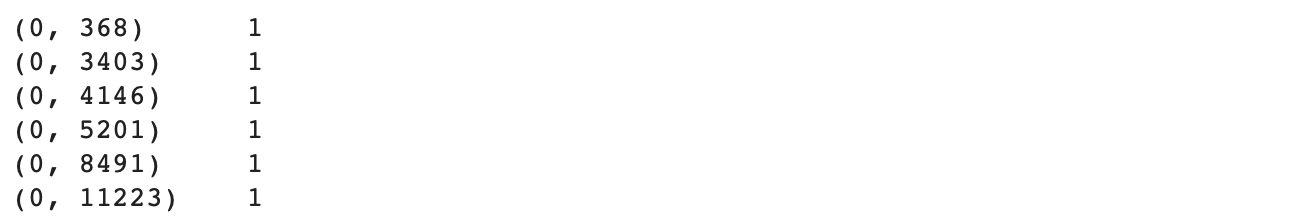

This image shows the first six rows of the CountVectorizer matrix. These rows tell us that in document 0, the words 368, 3403, 4146, 5201, 8491, and 11223 all appear once. We are interested in these counts because if a word appears many times in a document, that word is probably very significant.

TfidfTransformer simply transforms this matrix of token counts to a term frequency-inverse document frequency (tf-idf) representation. Using tf-idf is important because simply using token counts can be misleading. Previously, we assumed that if a word appeared many times in a document, it was important. What if that word is extremely common in the entire corpus? Then it’s high frequency in our current document would be less significant, because the word appears so frequently elsewhere.

Tf-idf strikes a balance by taking the term frequency (basically the count) and multiplying it by the inverse document frequency (1/document frequency). This means that if word 1 appears once in document A but also once in the total corpus, while word 2 appears four times in document A but 16 in the total corpus, word 1 will have a tf-idf score of 1.0 while word 2 will only receive a score of 0.25. Word 2’s importance in document A is diluted by its high frequency in the corpus. (This is a simplified explanation of the actual tf-idf equation, which is more complicated.)

Hence, we arrive at this representation of document 0:
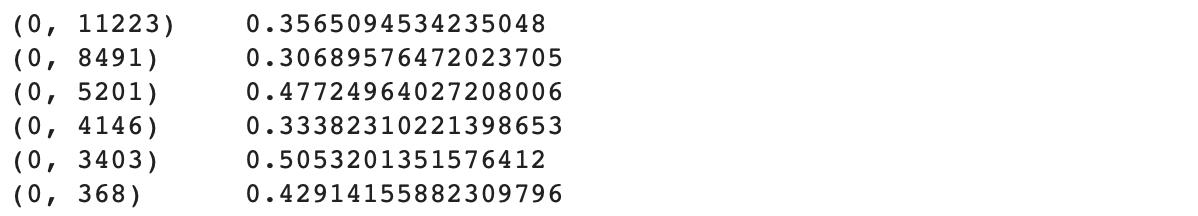

Notice that in the CountVectorizer representation, all the tokens in document 1 appeared only once. Now, in the tf-idf representation, some tokens have higher scores than others. Tf-idf has added a layer of nuance to our data.
Our data is not preprocessed and we are ready to move onto the modeling stage.

**Model**

Now is a good time to break our data into training set and a validation set.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [29]:
x = train_test_split(X, y)
x[3]

6703    0
7033    1
46      1
3881    0
831     0
       ..
543     0
3223    0
3957    1
1649    0
3449    0
Name: target, Length: 1904, dtype: int64

And now we can train our model, a logistic regression using scikit-learn.


In [22]:
scikit_log_reg = LogisticRegression()
model=scikit_log_reg.fit(X_train, y_train)

**Results**

Our model has been trained. Now let’s get its predictions for the validation set.

In [23]:
predictions = model.predict(X_test)


And the results of testing the model on our validation set?

In [24]:
count = 0
for guess, answer in zip(predictions, y_test):
    if guess == answer:
        count += 1
print(count/len(y_test))

0.792016806722689


This result is significantly better than flipping a coin, which is a good sign. To really know if our model is performing well, we would have to compare it to other people’s performance on the Kaggle leaderboards.

Preprocessing text data is a long process but is actually quite straightforward. Although the preprocessing for different text data science tasks may differ, learning about one text preprocessing example can be infinitely helpful when you have to do text preprocessing the next time. I hope you found this guide to text preprocessing with Python helpful.
If you want to finalize your Kaggle submission, the only remaining steps are using our trained model to predict for the test_transform data, formatting and exporting those results, and submitting them to Kaggle. These steps are shown in my Gist for this article here.